In [1]:
#@title PIP
!pip install -q kaggle

In [2]:
!pip install speedtest-cli

In [3]:
!speedtest-cli

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.23.91.152)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by Hivelocity (Atlanta, GA) [422.10 km]: 11.943 ms
Testing download speed................................................................................
Download: 2220.38 Mbit/s
Testing upload speed......................................................................................................
Upload: 569.29 Mbit/s


In [4]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from PIL import Image
import zipfile
import os
import torch
import json
from google.colab import userdata
import shutil
import kagglehub
from torchvision.utils import save_image, make_grid

## Downloading Dataset

#### Kaggle Dl

In [5]:
# kaggle_secret = json.loads(userdata.get("kaggle_json"))

# os.makedirs("/root/.kaggle", exist_ok=True)
# with open("/root/.kaggle/kaggle.json", "w") as f:
#   json.dump(kaggle_secret, f)
# os.chmod("/root/.kaggle/kaggle.json", 600)

In [6]:
# download_path = kagglehub.dataset_download("steubk/wikiart")

# local_path = "/content/wikiart"

# if os.path.exists(local_path):
#   shutil.rmtree(local_path)

# shutil.copytree(download_path, local_path)

# print("Dataset moved to:", local_path)

#### Convering to Pytorch Tensor

In [7]:
from PIL import Image
from torchvision import transforms
import torch
import os
from tqdm import tqdm

transform = transforms.Compose([
  transforms.Resize(128),
  transforms.CenterCrop(128),
  transforms.ToTensor(),
  transforms.Normalize([0.5]*3, [0.5]*3),
])

img_tensors = []
root_dir = "/content/wikiart"

image_paths = []
for class_dir in os.listdir(root_dir):
  full_class_path = os.path.join(root_dir, class_dir)
  if os.path.isdir(full_class_path):
    for fname in os.listdir(full_class_path):
      if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        image_paths.append(os.path.join(full_class_path, fname))

for path in tqdm(image_paths, desc="Processing images"):
  try:
    img = Image.open(path).convert("RGB")
    img_tensor = transform(img)
    img_tensors.append(img_tensor)
  except Exception as e:
    print("Skipped:", path, "due to", e)

dataset_tensor = torch.stack(img_tensors)
torch.save(dataset_tensor, "/content/wikiart_tensor_128.pt")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp /content/wikiart_tensor_128.pt /content/drive/MyDrive/wikiart_tensor_128.pt

In [10]:
!cp /content/drive/MyDrive/wikiart_tensor_128.pt /content/wikiart_tensor_128.pt

In [11]:
!ls -lh /content/wikiart_tensor_128.pt

-rw------- 1 root root 15G Jun  2 06:51 /content/wikiart_tensor_128.pt


## Model

In [17]:
!nvidia-smi

Mon Jun  2 06:51:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [18]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [19]:
print(f"Using device: {device}")

Using device: cuda


In [20]:
!ls

drive  sample_data  wikiart_tensor_128.pt


In [21]:
import argparse
import os
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from torch.cuda.amp import autocast, GradScaler

# ----------------------------
# Command-line arguments
# ----------------------------
os.makedirs("images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=100)
parser.add_argument("--batch_size", type=int, default=512)
parser.add_argument("--lr", type=float, default=0.0002)
parser.add_argument("--b1", type=float, default=0.5)
parser.add_argument("--b2", type=float, default=0.999)
parser.add_argument("--n_cpu", type=int, default=12)
parser.add_argument("--latent_dim", type=int, default=100)
parser.add_argument("--img_size", type=int, default=128)
parser.add_argument("--channels", type=int, default=3)
parser.add_argument("--sample_interval", type=int, default=400)
parser.add_argument("--tensor_dataset_path", type=str, default="/content/wikiart_tensor_128.pt")
opt = parser.parse_args(args=[])
print(opt)

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# ----------------------------
# Initialize weights
# ----------------------------
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# ----------------------------
# Generator
# ----------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = opt.img_size // 16  # 128 → 8
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 8x8 → 16x16
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),  # 16x16 → 32x32
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),  # 32x32 → 64x64
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2),  # 64x64 → 128x128
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# ----------------------------
# Discriminator
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def block(in_filters, out_filters, bn=True):
            layers = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Dropout2d(0.25)]
            if bn:
                layers.append(nn.BatchNorm2d(out_filters, 0.8))
            return layers

        self.model = nn.Sequential(
            *block(opt.channels, 16, bn=False),   # 128 → 64
            *block(16, 32),                        # 64 → 32
            *block(32, 64),                        # 32 → 16
            *block(64, 128),                       # 16 → 8
            *block(128, 256),                      # 8 → 4
            *block(256, 512),                      # 4 → 2
        )

        ds_size = opt.img_size // 2 ** 6  # 128 → 2
        self.adv_layer = nn.Linear(512 * ds_size ** 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity


# ----------------------------
# Setup
# ----------------------------

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

adversarial_loss = nn.BCEWithLogitsLoss().to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
scaler = GradScaler()

# ----------------------------
# Load preprocessed tensor dataset
# ----------------------------
print("Loading tensor dataset...")
imgs_tensor = torch.load(opt.tensor_dataset_path)
dataloader = DataLoader(
    TensorDataset(imgs_tensor),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)

# ----------------------------
# Training Loop
# ----------------------------
g_losses, d_losses = [], []

for epoch in range(opt.n_epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    n_batches = 0

    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{opt.n_epochs}") as pbar:
        for i, (real_imgs,) in enumerate(pbar):
            real_imgs = real_imgs.to(device, non_blocking=True)
            valid = torch.ones((real_imgs.size(0), 1), device=device)
            fake = torch.zeros((real_imgs.size(0), 1), device=device)

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            z = torch.randn(real_imgs.size(0), opt.latent_dim, device=device)
            with autocast():
                gen_imgs = generator(z)
                g_loss = adversarial_loss(discriminator(gen_imgs), valid)
            scaler.scale(g_loss).backward()
            scaler.step(optimizer_G)
            scaler.update()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            with autocast():
                real_loss = adversarial_loss(discriminator(real_imgs), valid)
                fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2
            scaler.scale(d_loss).backward()
            scaler.step(optimizer_D)
            scaler.update()

            # Accumulate loss
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            n_batches += 1

            pbar.set_postfix({"D loss": f"{d_loss.item():.4f}", "G loss": f"{g_loss.item():.4f}"})

            if (epoch * len(dataloader) + i) % opt.sample_interval == 0:
                save_image(gen_imgs[:25], f"images/{epoch:02d}_{i:04d}.png", nrow=5, normalize=True)

    # Store average losses per epoch
    g_losses.append(epoch_g_loss / n_batches)
    d_losses.append(epoch_d_loss / n_batches)

print("Training complete.")

Namespace(n_epochs=100, batch_size=512, lr=0.0002, b1=0.5, b2=0.999, n_cpu=12, latent_dim=100, img_size=128, channels=3, sample_interval=400, tensor_dataset_path='/content/wikiart_tensor_128.pt')


<ipython-input-21-8952c9dd8afd>:129: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Loading tensor dataset...


Epoch 1/100:   0%|          | 0/160 [00:00<?, ?it/s]<ipython-input-21-8952c9dd8afd>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-21-8952c9dd8afd>:178: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 100/100: 100%|██████████| 160/160 [00:16<00:00,  9.46it/s, D loss=1.3943, G loss=2.5905]

Training complete.


In [22]:
os.makedirs("checkpoints", exist_ok=True)
torch.save({
  'epoch': opt.n_epochs - 1,
  'generator_state_dict': generator.state_dict(),
  'discriminator_state_dict': discriminator.state_dict(),
  'optimizer_G_state_dict': optimizer_G.state_dict(),
  'optimizer_D_state_dict': optimizer_D.state_dict(),
  'g_losses': g_losses,
  'd_losses': d_losses
}, "checkpoints/gan_final.pth")

## Training Loss Curves

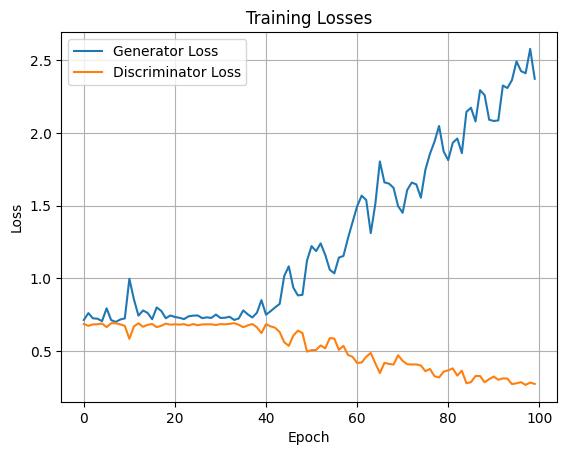

In [23]:
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid(True)
plt.show()

## Generate Sample Images

In [25]:
def sample_and_display(generator, n_row=6, latent_dim=100, device="cuda" if torch.cuda.is_available() else "cpu"):
  generator.eval()
  generator.to(device)

  z = torch.randn(n_row ** 2, latent_dim).to(device)

  with torch.no_grad():
    gen_imgs = generator(z).cpu()

  grid = make_grid(gen_imgs, nrow=n_row, normalize=True)

  np_grid = grid.permute(1, 2, 0).numpy()
  plt.figure(figsize=(8, 8))
  plt.imshow(np_grid)
  plt.axis("off")
  plt.title("Generated Samples")
  plt.show()

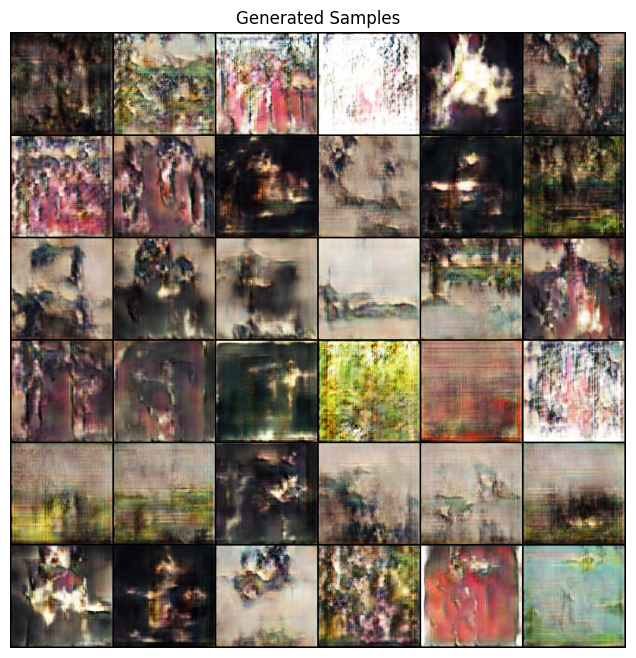

In [26]:
sample_and_display(generator, n_row=6, latent_dim=opt.latent_dim)

## Evaluation

In [28]:
!pip install torch-fidelity

  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl (127.9 MB)
  Attempting uninstall: nvidia-cusolver-cu12
    Found existing installation: nvidia-cusolver-cu12 11.6.3.83
    Uninstalling nvidia-cusolver-cu12-11.6.3.83:
      Successfully uninstalled nvidia-cusolver-cu12-11.6.3.83


In [29]:
os.makedirs("generated_images", exist_ok=True)
generator.eval()
with torch.no_grad():
  for i in range(10000):
    z = torch.randn(1, opt.latent_dim).to(device)
    gen_img = generator(z)
    save_image(gen_img, f"generated_images/{i:05d}.png", normalize=True)

In [31]:
import torch
from torchvision.utils import save_image

os.makedirs("real_images", exist_ok=True)
tensor = torch.load("wikiart_tensor_128.pt")  # shape: [N, 3, 128, 128]

for i in tqdm(range(min(5000, tensor.shape[0]))):
  save_image(tensor[i], f"real_images/{i:05d}.png", normalize=True)

100%|██████████| 5000/5000 [00:26<00:00, 186.49it/s]


In [34]:
!ls real_images | head
!ls generated_images | head

00000.png
00001.png
00002.png
00003.png
00004.png
00005.png
00006.png
00007.png
00008.png
00009.png
00000.png
00001.png
00002.png
00003.png
00004.png
00005.png
00006.png
00007.png
00008.png
00009.png


In [35]:
!fidelity --input1 real_images --input2 generated_images --isc --fid

Creating feature extractor "inception-v3-compat" with features ['logits_unbiased', '2048']
Extracting features from input1
Looking for samples non-recursivelty in "real_images" with extensions png,jpg,jpeg
Found 5000 samples
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "generated_images" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Inception Score: 7.501669995910606 ± 0.26114875352614336
Frechet Inception Distance: 252.6573084746958
inception_score_mean: 7.50167
inception_scor